### Описание проекта
**Цель:**
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов(500 пользователей «Мегалайна») Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

<b>*Тариф «Смарт»:*</b>
Ежемесячная плата: 550 рублей</b>
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Шаг 1.  Изучение и знакомство с данными<a id="start"></a>

In [2]:
# Загрузим библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Загрузим данные
calls = pd.read_csv('/content/calls.csv')
internet = pd.read_csv('/content/internet.csv')
msg = pd.read_csv('/content/messages.csv')
trfs = pd.read_csv('/content/tariffs.csv')
users = pd.read_csv('/content/users.csv')
calls.info()
internet.info()
msg.info()
trfs.info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 co

In [5]:
display(calls.head())
display(internet.head())
display(msg.head())
display(trfs.head())
display(users.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


#### Вывод<a id="result"></a>
1. Необходимо перевести даты в формат датетайм и выделить категорию месяц;
2. Посчитать нулевые значеия и принять решение о их удалении/использовании;
3. Округлить `duration` и `mb_used` до верхних значей, даже где значение равно 0,01.
4. Создать новые сводные таблицы и соединить их для подсчета общих данных.

### Шаг 2. Подготовка данных для анализа<a id="reserch"></a>
- Приведем данные к нужным типам;
- Найдем и исправим ошибки в данных.
- Оценим потерю данных при удалении 0 звонков

Необходимо посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

1. Проверка датасета **calls**<a id="calls"></a>

In [6]:
# Перевод данных в формат datetime
# выделение месцев в цифровом формате для сортировки
# Округление до целых минут.
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%dT')
calls['mounth'] = calls['call_date'].dt.month
calls['duration'] = calls['duration'].apply(np.ceil)
calls.head()

,id,call_date,duration,user_id,mounth
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


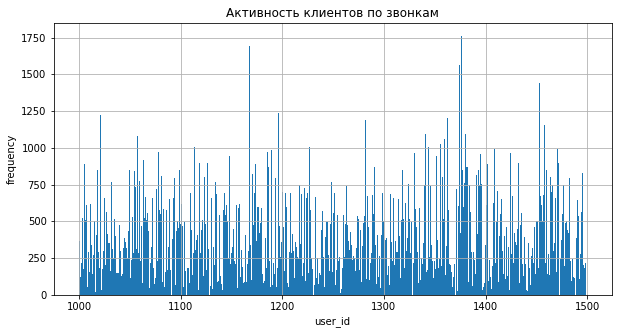

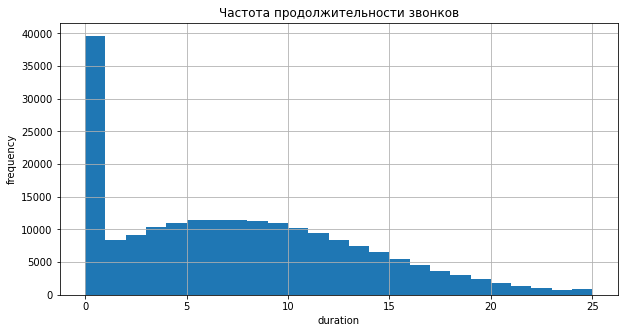

In [7]:
# Оценим странные зачения, частотность, наличие пропусков, распределение
calls['user_id'].hist(bins=500,figsize=(10,5))
plt.xlabel('user_id')
plt.ylabel('frequency')
plt.title('Активность клиентов по звонкам')
plt.show()
calls['duration'].hist(bins=25,figsize=(10,5), range=(0, 25))
plt.xlabel('duration')
plt.ylabel('frequency')
plt.title('Частота продолжительности звонков')
plt.show()

1. Исходя из первого графика видно, что не все клиенты используют звонки, скорее всего они используют сим-карты в планшете, ноутбуке. Стоит учесть это при соединении таблиц;
2. Второй график нам показывает нормальное распределение, если закрыть глаза на быстрые звонки - 0 секунд. Основная часть клиентов тратить на разговор от 4 до 8 минут.

In [8]:
calls['duration'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

- разница между средним и медианой 1,158;
- сркв.отклонение - 5,95;
- данные смещены в права

Удалим нулевые значения и посмотрим еще раз на график:

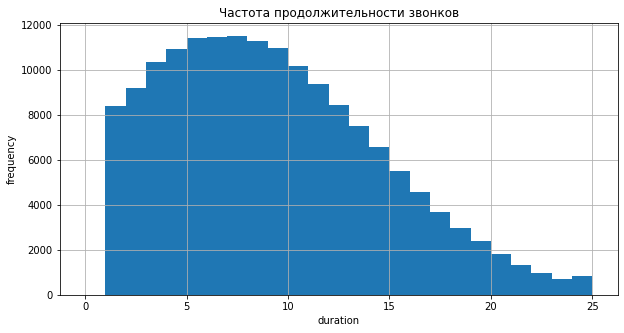

In [9]:
calls['duration'] = calls['duration'].replace(0,np.nan)
calls['duration'] = calls['duration'].dropna()
calls['duration'].hist(bins=25,figsize=(10,5), range=(0, 25))
plt.xlabel('duration')
plt.ylabel('frequency')
plt.title('Частота продолжительности звонков')
plt.show()

In [10]:
calls['duration'].describe()

count    162994.000000
mean          8.897880
std           5.353761
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: duration, dtype: float64

- Распределение сместилось вправо, разница между средним и медианой 0,89;
- Отклонение уменьшилось до 5.35;
- Нулевые значения составляют 20% выборки, но это скорее всего дозвоны по тарифу "Чайка", либо пропущенные. Они влиют на кол-во звонков, но не влияют на тариф, т.к. считаются, только звонки с 1 сек. Предлагаю их удалить, т.к. их удаление уменьшает разницу между средней и медианой, и среднеквадратическое отклонение.

*Создадим сводную таблицу по сумме минут и кол-ву звоноков:*

In [11]:
df_c = calls.pivot_table(index=['user_id','mounth'], values = 'duration', aggfunc = ['count','sum']).reset_index()
df_c.columns=['user_id','mounth','dur_count','dur_sum']
df_c.head()

,user_id,mounth,dur_count,dur_sum
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0
3,1000,8,42,408.0
4,1000,9,46,466.0


2. Проверка датасета **internet.**<a id="internet"></a>

In [12]:
# удалим странный столбец, округлим использованные 'mb', выделим месяцы из даты
internet.drop(['Unnamed: 0'],axis ='columns', inplace=True)
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%dT')
internet['mounth'] = internet['session_date'].dt.month
#internet.head()

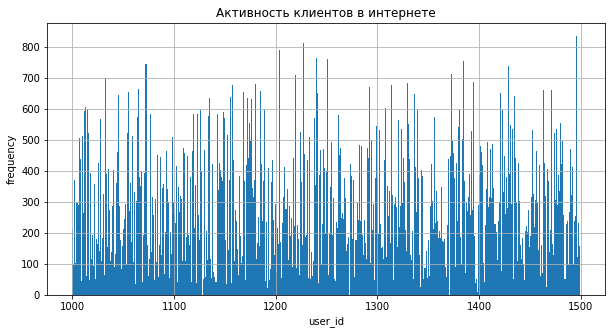

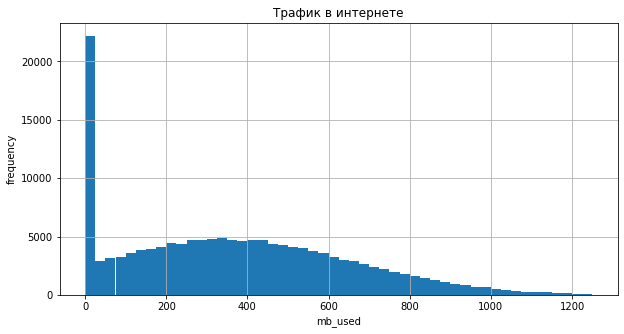

In [13]:
internet['user_id'].hist(bins=500, figsize=(10,5))
plt.xlabel('user_id')
plt.ylabel('frequency')
plt.title('Активность клиентов в интернете')
plt.show()
internet['mb_used'].hist(bins=50, figsize=(10,5), range=(0,1250))
plt.xlabel('mb_used')
plt.ylabel('frequency')
plt.title('Трафик в интернете')
plt.show()

1. Из первого графика видно, что интернет используют большее кол-во клиентов, только 3 клиента не используют интернет, либо они ходят с Nokia 3310 до сих пор, либо им его заблокировали (разные ситуации бывают)
2. Второй график показывает нам нормальное распределение, основная часть трафика от 300 до 450 мб за сессию. Нулевые значения не трогаем, т.к. они не влияют на тариф. Хотя у некоторых операторов, если не безлимит по интернету, даже случайных заход в интернет считается за 1 мб.



In [14]:
internet['mb_used'].describe()

count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64

*Построим сравнительну таблицу суммарного использования интернета:*

In [15]:
# Поработаем с датой, округлим "МБ" до "ГБ".
df_int = internet.pivot_table(index=['user_id','mounth'], values = 'mb_used', aggfunc = ['sum']).reset_index()
df_int.columns=['user_id','mounth','gb_sum']
df_int['gb_sum'] = np.ceil(df_int['gb_sum'] / 1024)
df_int.head()

,user_id,mounth,gb_sum
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


3. Проверка датасета **msg.**<a id="msg"></a>

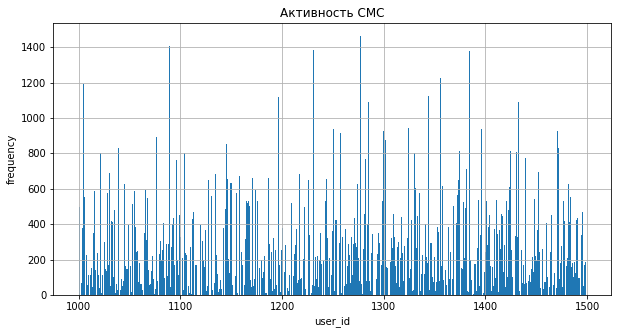

In [16]:
# Выделим месяц, посмотрим на данные с помощью гистограмм. 
msg['message_date'] = pd.to_datetime(msg['message_date'], format='%Y-%m-%dT')
msg['mounth'] = msg['message_date'].dt.month
msg['user_id'].hist(bins=500, figsize=(10,5))
plt.xlabel('user_id')
plt.ylabel('frequency')
plt.title('Активность СМС')
plt.show()

Из графика видно, что с приходом мессенджеров, актуальность СМС теряет.

"Хотя в лесу может и жизь спасти"

*Создадим сравнительную таблицу*

In [17]:
df_msg = msg.pivot_table(index=['user_id','mounth'], values = 'message_date', aggfunc = ['count']).reset_index()
df_msg.columns=['user_id','mounth','count_msg']
# df_msg.head()

4. Объединение всех вышепровереные таблицы:<a id="merge"></a>

Text(0.5, 1.0, 'Активность клиентов')

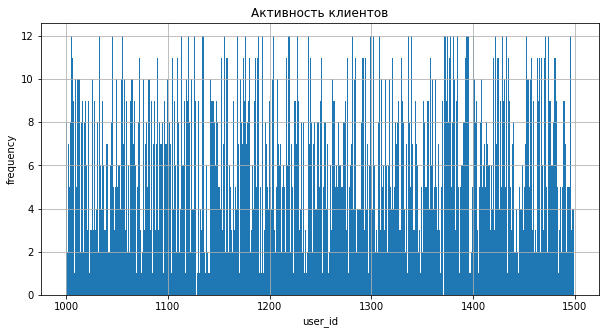

In [18]:
df = df_c.merge(df_int, on=['user_id', 'mounth'], how = 'outer')
df = df.merge(df_msg, on=['user_id', 'mounth'], how = 'outer')
df['user_id'].hist(bins=500, figsize=(10,5))
plt.xlabel('user_id')
plt.ylabel('frequency')
plt.title('Активность клиентов')

In [19]:
df.loc[(df['user_id'] == 1128) | (df['user_id'] == 1371)].head()

,user_id,mounth,dur_count,dur_sum,gb_sum,count_msg


In [20]:
users.loc[(users['user_id'] == 1128) | (users['user_id'] == 1371)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


- Путем увеличения графика были выявлены 2 клиента 1128 и 1371, которые не пользовались услугами;
- Ксения Агеева и Ириней Трофимов заключили и рассторгли контракт в декабре, не пользовались услугой;
- Предположим, что с этих клиентов мы не взяли ничего, они заплатили, не воспользовались тарифом, мы им вернули деньги, как добропорядочный оператор;
- ***Хотя, скорее всего, у нас есть в договоре мелкий шрифт, где оговорено, что в случае рассторжения договора сумма внесенной платы за месяц не возвращается***.

In [21]:
# Обработаем даты в таблице 'users'
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%dT')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%dT')

In [22]:
df = df.merge(users, on='user_id', how='left')
df.tail()

,user_id,mounth,dur_count,dur_sum,gb_sum,count_msg,age,churn_date,city,first_name,last_name,reg_date,tariff
3209,1489,8,NaN,NaN,11.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3210,1489,9,NaN,NaN,17.0,32.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3211,1489,10,NaN,NaN,20.0,21.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3212,1489,11,NaN,NaN,18.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3213,1489,12,NaN,NaN,17.0,35.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


In [23]:
# Таблицы были с пропусками по минутам, мб и сообщениям,
# нужно заменить NaN на 0, чтобы дальнейшие расчеты не споткнулись об них.
df['dur_count'] = df['dur_count'].fillna(0)
df['dur_sum'] = df['dur_sum'].fillna(0)
df['gb_sum'] = df['gb_sum'].fillna(0)
df['count_msg'] = df['count_msg'].fillna(0)

5. Подсчет выручки по каждому клиенту<a id="def"></a>

In [24]:
def dur_profit(row):
    profit=0
    if row['tariff'] == 'smart' and row['dur_sum'] <= 500:
        return 550
    if row['tariff'] == 'smart' and row['dur_sum'] > 500:
        profit = ((row['dur_sum'] - 500) * 3) + 550
        return profit
    if row['tariff'] == 'ultra' and row['dur_sum'] <= 3000:
        return 1950
    if row['tariff'] == 'ultra' and row['dur_sum'] > 3000:
        profit = ((row['dur_sum'] - 3000) * 1) + 1950
        return profit
    
df['dur_profit'] = df.apply(dur_profit, axis=1)

In [25]:
def int_profit(row):
    profit=0
    if row['tariff'] == 'smart' and row['gb_sum'] <= 15:
        return 0
    if row['tariff'] == 'smart' and row['gb_sum'] > 15:
        profit = ((row['gb_sum'] - 15) * 200)
        return profit
    if row['tariff'] == 'ultra' and row['gb_sum'] <= 30:
        return 0
    if row['tariff'] == 'ultra' and row['gb_sum'] > 30:
        profit = ((row['gb_sum'] - 30) * 150)
        return profit
    
df['int_profit'] = df.apply(int_profit, axis=1)

In [26]:
def msg_profit(row):
    profit=0
    if row['tariff'] == 'smart' and row['count_msg'] <= 50:
        return 0
    if row['tariff'] == 'smart' and row['count_msg'] > 50:
        profit = ((row['count_msg'] - 50) * 3)
        return profit
    if row['tariff'] == 'ultra' and row['count_msg'] <= 1000:
        return 0
    if row['tariff'] == 'ultra' and row['count_msg'] > 1000:
        profit = ((row['count_msg'] - 1000) * 1)
        return profit
    
df['msg_profit'] = df.apply(msg_profit, axis=1)

In [27]:
df['all_profit'] = df['dur_profit'] + df['int_profit'] + df['msg_profit']

In [28]:
df[df['all_profit'].isna()].head() # все корректно обрабтано

,user_id,mounth,dur_count,dur_sum,gb_sum,count_msg,age,churn_date,city,first_name,last_name,reg_date,tariff,dur_profit,int_profit,msg_profit,all_profit


In [29]:
df[df['all_profit'] == 0].head() # все корректно обрабтано

,user_id,mounth,dur_count,dur_sum,gb_sum,count_msg,age,churn_date,city,first_name,last_name,reg_date,tariff,dur_profit,int_profit,msg_profit,all_profit


In [30]:
df.head()

,user_id,mounth,dur_count,dur_sum,gb_sum,count_msg,age,churn_date,city,first_name,last_name,reg_date,tariff,dur_profit,int_profit,msg_profit,all_profit
0,1000,5,17.0,159.0,3.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0,0.0,0.0,1950.0
1,1000,6,28.0,172.0,23.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0,0.0,0.0,1950.0
2,1000,7,41.0,340.0,14.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0,0.0,0.0,1950.0
3,1000,8,42.0,408.0,14.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0,0.0,0.0,1950.0
4,1000,9,46.0,466.0,15.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0,0.0,0.0,1950.0


#### Вывод<a id="result2"></a>
- Обработали данные и сформировали общую таблицу:
    - с количеством сделанных звонков и израсходованных минут по месяцам;
    - с количеством отправленных сообщений по месяцам;
    - с объемом израсходованного интернет-трафика по месяцам;
    - с помесячной выручкой по каждому пользователю;

### Шаг 3. Анализ данных<a id="reserch2"></a>

Необходимо описать:
- сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц;
- посчитать среднее количество, дисперсию и стандартное отклонение;
- построить гистограммы. Описать распределения.

In [31]:
# Найдем значения тарифа smart по месяцам
pd.set_option('display.float_format', '{:.0f}'.format)
(df
 .query('tariff == "smart"')
 .pivot_table(index=['tariff', 'mounth'], values = ['dur_sum','gb_sum','count_msg'], aggfunc = ['sum', 'mean']).reset_index()
)

tariff mounth       sum                     mean               
                 count_msg dur_sum gb_sum count_msg dur_sum gb_sum
0   smart      1       620    6931    297        18     204      9
1   smart      2      1397   17324    687        24     299     12
2   smart      3      2453   30034   1174        32     390     15
3   smart      4      3443   41119   1528        31     367     14
4   smart      5      4762   54618   2248        34     387     16
5   smart      6      5478   64885   2621        33     396     16
6   smart      7      6784   82079   3198        34     408     16
7   smart      8      7905   99045   3944        34     421     17
8   smart      9      8746  111439   4270        34     429     16
9   smart     10      9927  125284   4972        34     426     17
10  smart     11     10768  137544   5381        34     435     17
11  smart     12     12130  161275   6145        36     479     18

In [32]:
# Найдем значения тарифа ultra по месяцам
(df
 .query('tariff == "ultra"')
 .pivot_table(index=['tariff', 'mounth'], values = ['dur_sum','gb_sum','count_msg'], aggfunc = ['sum', 'mean']).reset_index()
)

tariff mounth       sum                     mean               
                 count_msg dur_sum gb_sum count_msg dur_sum gb_sum
0   ultra      1       304    3853    120        34     428     13
1   ultra      2       527    7131    288        22     297     12
2   ultra      3      1195   18117    655        32     490     18
3   ultra      4      1736   25191    935        32     458     17
4   ultra      5      2536   34192   1302        38     510     19
5   ultra      6      3505   40295   1593        42     480     19
6   ultra      7      4536   49667   1869        50     546     21
7   ultra      8      5183   54653   2101        48     511     20
8   ultra      9      6013   62036   2214        52     539     19
9   ultra     10      7187   68644   2471        58     558     20
10  ultra     11      7476   72545   2657        56     541     20
11  ultra     12      8425   82400   3028        61     593     22

**Вывод**
- Клиенты тарифа "smart" в 2 раза больше наговорили минут и просидели в интернете, чем клиенты "ultra". 
- От месяца к месяцу видно как значения увеличиваются - это говорит о том, что к тарифам подключаются новые клиенты, к дешевому тарифу подключаются чаще, поэтому динамика увеличения общих показателей имеет большую прогрессию;
- Хотя средние значения показателей выше у тарифа "ultra", прогрессия выше. 

***Деление датасета по тарифам***<a id="del_tariff"></a>

In [33]:
# Разделим датасет по тарифам
df_smart = df.query('tariff == "smart"')
df_1=df_smart.loc[:, ['dur_sum', 'gb_sum', 'count_msg', 'all_profit']]
# Определим средние значения для тарифа "smart"
display(df_1.mean())
display(len(df_1))

dur_sum       418
gb_sum         16
count_msg      33
all_profit   1295
dtype: float64

2229

In [34]:
df_ultra = df.query('tariff == "ultra"')
df_2=df_ultra.loc[:, ['dur_sum', 'gb_sum', 'count_msg', 'all_profit']]
# Определим средние значения для тарифа "ultra"
display(df_2.mean())
display(len(df_2))

dur_sum       527
gb_sum         20
count_msg      49
all_profit   2071
dtype: float64

985

**Вывод**
- Среднее значение суммарных минут, gb, сообщений, выручки у тарифа "ultra' выше;
- Выборка у тарифа смарт в 2 раза больше, чем выборка тарифа ультра (не каждый готов заплатить 1950 в месяц).

***Определение дисперсии***<a id="var"></a>

In [35]:
variance_smart = np.var(df_1, ddof=1)
display(variance_smart)

dur_sum       36219
gb_sum           33
count_msg       797
all_profit   673931
dtype: float64

In [36]:
variance_ultra = np.var(df_2, ddof=1)
display(variance_ultra)

dur_sum      100874
gb_sum           97
count_msg      2285
all_profit   143491
dtype: float64

**Вывод**
- большой разброс имеют значения минут, гб, сообщений в тарифе "ultra", а также большой разброс имеет выручка у тарифа "smart"

***Определение стандартного отклонение***<a id="std"></a>

In [37]:
std_smart = np.std(df_1, ddof=1)
display(std_smart)

dur_sum      190
gb_sum         6
count_msg     28
all_profit   821
dtype: float64

In [38]:
std_ultra = np.std(df_2, ddof=1)
display(std_ultra)

dur_sum      318
gb_sum        10
count_msg     48
all_profit   379
dtype: float64

***Вывод***
- Отклонения как и дисперсия выше у тарифа "ultra", а вот выручка у тарифа "smart" выходит в лидеры. Кто-то не оценил своих способностей поболтать и посидеть в интернете и выбился из тарифа, тем самым увеличив выручку оператору.
- Правило 3 сигм, определение выбросов: 
    1. Тариф смарт: минуты = 418+3*190 = 988; гб=16+18 = 34; смс=33+3*28=117; выручка=1295+3*821=3758;
    2. Тариф ультра: минуты = 527+3*318 = 1481; гб=20+30 = 50; смс=49+3*48=193; выручка=2071+3*379=3208(меньше 1950 не может быть);

***Построение гистограмм и оценка распределения***<a id="hist"></a>

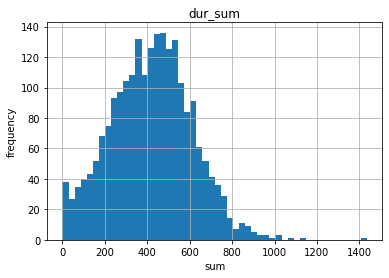

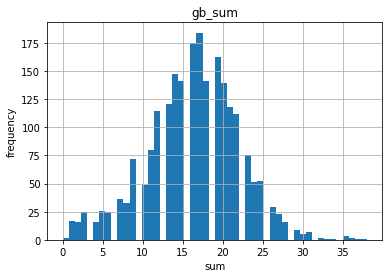

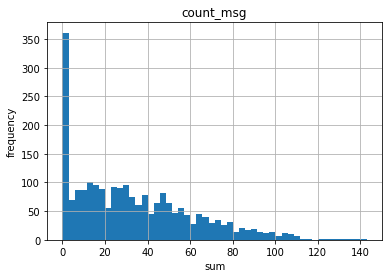

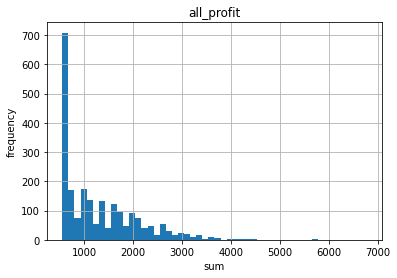

In [39]:
def show_me_hist(df, i):
    df[df.columns.values[i]].hist(bins=50)
    plt.xlabel('sum')
    plt.ylabel('frequency')
    plt.title(df.columns.values[i])
    plt.show()

for i in range(4):
    show_me_hist(df_1, i)
# тариф смарт

***Вывод***
- Основная масса использует тариф по назначению, есть небольшое кол-во использующих сим-карту в планшете или модеме(нет расхода минут), также есть выбросы в виде отдельных личностей, отличающихся особой болтливостью, либо они забыли какой тариф подключили - нормальное распределение, скошен вправо;
- вот с интернетом дела плохи, всем нужно больше "гигабайт" в среднем 20! Но зато оператор получает значительно больше денег за счет гигабайт вне тарифа - нормальное распределение, скошен вправо;
- СМС - большинство либо вовсе ими не пользуется, либо укладывается в тариф, но есть и адепты СМС, но тариф менять не хотят - большое 0 значение, но нормальное распределение, скошен вправо;
- Выручка - треть выборки платит абонентскую плату не выходя за рамки, остальным тарифа не хватает, и они вынуждены платить даже больше, чем в тарифе "ультра". Дальше 3758 - уже выбросы, есть даже больше 5500(наверно ребенок нашел папин телефон и ни в чем себе не отказывал), максимум тарифа ультра - не доходит до 4000.

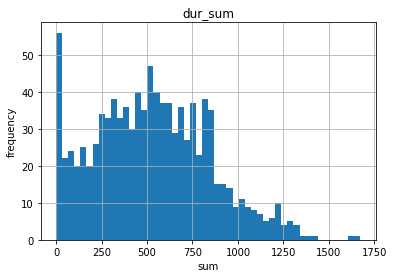

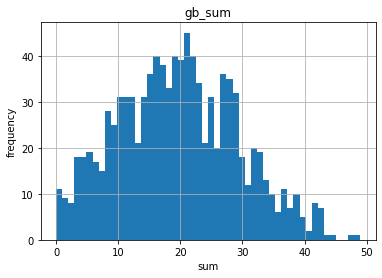

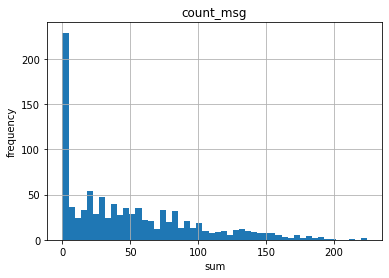

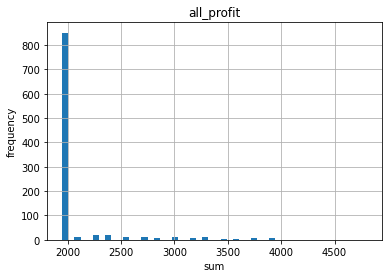

In [40]:
for i in range(4):
    show_me_hist(df_2, i)
# тариф ультра

***Выводы***
- Тариф "ультра" многие приобретают для серфинга в интернете, т.к. если на тарифе смарт превысить лимит, то можно попась еще на +3000 рублей за ГБ;
- Данный тариф, хоть и имеет 3000 бесплатных минут, многие их вообще не используют, т.к. симка в планшете, а большая часть разговаривает до 800 минут, никто из клиентов не выходил за рамки дозволенного;
- Предельный объем трафика большую часть клиентов устраивает, т.к. основная часть выборки до 30 гб;
- СМС - как и в тарифе "смарт" теряет актуальность, но клиенты этого тарифа пользуются СМС чаще практически в 2 раза;
- Выручка - практически вся выборка входит в рамки тарифа за 1950, но есть минимальное кол-во клиентов, которые выходят за рамки по трафику в интернете.

### Шаг 4. Проверка гипотезы<a id="reserch3"></a>

***Первая гипотеза***, которую нужно проверить:

Формулировка двухсторонних гипотез заключается в том, что нулевая гипотеза должна иметь знак равенства:
- H₀: Cредние выручки пользователей тарифов «Ультра» и «Смарт» равны.
- H₁: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

Чтобы проверить гипотезу о равенстве/неравенстве среднего двух выборок применим метод scipy.stats.ttest_ind (array1, array2, equal_var) .

In [41]:
# Подготоовим выборки по тарифной выручке со всех клиентов
df_s_prof=df_smart.loc[:, ['all_profit']]
df_u_prof=df_ultra.loc[:, ['all_profit']]
# сравним дисперсии методом Левене, чтобы понять какой параметр equal_var указывать
from scipy.stats import levene
sample1=df_s_prof['all_profit'].tolist()
sample2=df_u_prof['all_profit'].tolist()
stat, p = levene(sample1, sample2)
p

1.6855369377883898e-124

- Можно сделать вывод, что дисперсии выборок не равны и поэтому нужно использовать параметр equal_var=False.

In [42]:
# Дополнительно сравним дисперсии
[np.var(x, ddof=1) for x in [df_s_prof['all_profit'], df_u_prof['all_profit']]]

[673931.3213632498, 143491.2405596106]

In [43]:
from scipy import stats as st
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем нулевую гипотезу
results = st.ttest_ind(
    sample1, 
    sample2, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


***Вывод***
1. Полученное значение p-value отвергает нулевую гипотезу H₀. Это говорит о том, что средние выручки тарифов с большой вероятностью различны и нельзя сказать о их равенстве.

***Вторая гипотеза***, которую нужно проверить:
- H₀: Cредние выручки пользователей из Москвы и других регионов равны; 
- H₁: Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [44]:
# Подготовим выборки клиентов из Москвы
df_m = df.query('city == "Москва"')
df_m_p = df_m.loc[:,['all_profit']]
df_m_p.describe()

,all_profit
count,611
mean,1551
std,752
min,550
25%,798
50%,1750
75%,1950
max,5321


In [45]:
# Из других городов
df_other = df.query('city not in "Москва"')
df_other_p = df_other.loc[:,['all_profit']]
df_other_p.describe()

,all_profit
count,2603
mean,1528
std,810
min,550
25%,750
50%,1587
75%,1950
max,6770


Если посмотреть на две выборки, мы увидим, что выборка других городов больше в 4,3 раза выборки из Москвы. Но среднее и отклонение выручки примерно равны. Есть предположение, что наша нулевая гипотеза с большей вероятностью не будет отвергнута. 

In [46]:
# сравним дисперсии методом Левене, чтобы понять какой параметр equal_var указывать
sample_1=df_m_p['all_profit'].tolist()
sample_2=df_other_p['all_profit'].tolist()
stat, p = levene(sample_1, sample_2)
p

0.009373921759468934

- Дисперсии близки, но не равны, применим параметр equal_var = False

In [47]:
# Дополнительно сравним дисперсии
[np.var(x, ddof=1) for x in [sample_1, sample_2]]

[566183.0292184273, 656766.5955122437]

In [48]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем нулевую гипотезу
results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


***Вывод***
- Полученное значение p-value не отвергает нулевую гипотезу и говорит о том, что хотя средняя выручка от клиентов из Москвы и других регионов неодинаковы, с вероятностью в почти 51% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними.

### Шаг 5. Общий вывод<a id="total_result"></a>

**Была проведена подготовка данных к анализу:**
- удалены быстрые звонки 0 сек. - это привело к улучшению столбца суммарных минут, снизилось отклонение от среднего;
- удалены пользователи, не пользующиеся услугой и расторгнувшие договор в течение 5 дней после заключения;
- определена общая выручка по тарифам за месяц на каждого клиента.

**В ходе анализа было выявлено:**
- Выборка у тарифа "Смарт" в 2 раза больше, чем выборка тарифа "Ультра" (не каждый готов заплатить 1950 в месяц);
- От месяца к месяцу видно как значения увеличиваются - это говорит о том, что к тарифам подключаются новые клиенты, к дешевому тарифу подключаются чаще, поэтому динамика увеличения общих показателей имеет большую прогрессию;
- Хотя средние значения показателей выше у тарифа "ultra";
- Отклонение как и дисперсия основных показателей выше у тарифа "ultra", а вот отклонение выручки у тарифа "smart". Кто-то не оценил своих способностей поболтать и посидеть в интернете и выбился из тарифа, тем самым увеличив выручку оператору;
- По правилу 3 сигм, определены выбросы:
    - Тариф смарт: дальше значений - минуты=988; гб=34; смс=117; выручка=3758;
    - Тариф ультра: минуты=1481; гб=50; смс=193; выручка=3208(меньше 1950 не может быть);
    
**Описание поведения клиентов:**

Тариф "Смарт":
- Основная масса использует тариф по назначению, есть небольшое кол-во использующих сим-карту в планшете или модеме(нет расхода минут), также есть выбросы в виде отдельных личностей, отличающихся особой болтливостью, либо они забыли какой тариф подключили.
- вот с интернетом дела плохи, всем нужно больше "гигабайт" в среднем 20!
- СМС - большинство либо вовсе ими не пользуется, либо укладывается в тариф, но есть и адепты СМС, но тариф менять не хотят.
- выручка - треть выборки платит абонентскую плату не выходя за рамки, остальным тарифа не хватает, и они вынуждены платить даже больше, чем в тарифе "ультра". Дальше 3758 - уже выбросы, есть даже больше 5500.

Тариф "Ультра":
- Тариф "ультра" многие приобретают для серфинга в интернете, т.к. если на тарифе смарт превысить лимит, то можно попась еще на +3000 рублей за ГБ;
- Данный тариф, хоть и имеет 3000 бесплатных минут, многие их вообще не используют, т.к. симка в планшете, а большая часть разговаривает до 800 минут, никто из клиентов не выходил за рамки дозволенного;
- Предельный объем трафика большую часть клиентов устраивает, т.к. основная часть выборки до 30 гб;
- СМС - как и в тарифе "смарт" теряет актуальность, но клиенты этого тарифа пользуются СМС чаще практически в 2 раза;
- Выручка - практически вся выборка входит в рамки тарифа за 1950, но есть минимальное кол-во клиентов, которые выходят за рамки по трафику в интернете.

**Гипотезы:**
1. Первая гипотеза "Cредние выручки пользователей тарифов «Ультра» и «Смарт» равны": Полученное значение p-value отвергает нулевую гипотезу H₀. Это говорит о том, что средние выручки тарифов с большой вероятностью различны и нельзя сказать о их равенстве.
2. Вторая гипотеза "Cредние выручки пользователей из Москвы и других регионов равны": Полученное значение p-value не отвергает нулевую гипотезу и говорит о том, что хотя средняя выручка от клиентов из Москвы и других регионов неодинаковы, с вероятностью в почти 51% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними.